In [1]:
import chardet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
import string
import nltk
import spacy
from PIL import Image
from wordcloud import WordCloud

nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') #pos_tag

import en_core_web_sm
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import files

# Choose the file from your local machine
uploaded = files.upload()

Saving data_world.csv to data_world.csv
Saving kaggle.csv to kaggle.csv


### Data Cleaning

In [3]:
# Detect encoding
with open("data_world.csv", 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

# Read CSV with detected encoding
data_world_df = pd.read_csv("data_world.csv", encoding=encoding, on_bad_lines='skip')

# After skipping on bad lines, there are now 6090 rows in this dataset

# Remove duplicate tweets
data_world_df = data_world_df.drop_duplicates(subset='tweet', keep='first')

# Number of rows after dropping duplicates is now 5541
# Change representation of 'existence' values
data_world_df['existence'] = data_world_df['existence'].map({'Yes': 1, 'No': -1, 'N/A': 0})

In [4]:
# Detect encoding
with open("kaggle.csv", 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

# Read CSV with detected encoding
kaggle_df = pd.read_csv("kaggle.csv", encoding=encoding, on_bad_lines='skip')

# Remove duplicate tweets
kaggle_df = kaggle_df.drop_duplicates(subset='message', keep='first')

# Remove rows where sentiment is labeled as News (value = 2)
kaggle_df = kaggle_df.loc[kaggle_df['sentiment'] != 2]

In [5]:
df_selected_columns = data_world_df[['tweet', 'existence']].rename(columns={'tweet': 'og_tweet','existence': 'label'})
df_kaggle_selected_columns = kaggle_df[['message', 'sentiment']].rename(columns={'message': 'og_tweet', 'sentiment': 'label'})

# Concatenate the two DataFrames vertically
df = pd.concat([df_selected_columns, df_kaggle_selected_columns], ignore_index=True)


In [6]:
#df.label.value_counts()
#df.info()

In [7]:
# 5066 rows with missing labels
missing_label_rows = df[df['label'].isnull()]
df.dropna(subset=['label'], inplace=True)

# Now the number of rows for both columns are equal
#df.info()
#round(df['label'].value_counts()*100/len(df),2)

In [8]:
print(len(df))
'''
Initializing a dataframe to store tweets awaiting classification labels
based on the selected model.
'''
test_df = df['og_tweet'].sample(n=7500, random_state=42)

# Remove selected tweets from the DataFrame
df = df.drop(test_df.index)


32435


In [9]:
# Extracting hashtags from dataset for visualization later
# before tweets undergo pre-processing
def extract_top_hashtags(tweets):

  hashtags_list = []

  for tweet in tweets:
      hashtags = re.findall(r"#(\w+)", tweet)
      hashtags_list.extend(hashtags)

  frequency = nltk.FreqDist(hashtags_list)

  hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()), 'count': list(frequency.values())})

  # Select the top 15 hashtags
  hashtag_df = hashtag_df.nlargest(15, columns="count")

  return hashtag_df

# Extracting the hashtags from tweets in each class
pro_hashtags = extract_top_hashtags(df['og_tweet'][df['label'] == 1])
anti_hashtags = extract_top_hashtags(df['og_tweet'][df['label'] == -1])
neutral_hashtags = extract_top_hashtags(df['og_tweet'][df['label'] == 0])


### Data Pre-Processing

In [10]:
# Pre-processing
def clean_tweet(tweet):

  # Remove retweet texts "RT"
  tweet = re.sub(r'^RT[\s]+', '', tweet)

  # Converting to lower case
  tweet = tweet.lower()

  # Remove hyperlinks: both http and https
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', tweet)
  tweet = re.sub(r"http\S+", '', tweet)

  # Remove placeholders saying [link] which was done by prior text cleaning
  tweet = re.sub(r'\[link\]', '', tweet)

  # Remove hashtags (only removing the hash # sign from the word)
  tweet = re.sub(r'#', '', tweet)

  # Remove numbers
  tweet = re.sub(r'\d+', '', tweet)

  # Remove mentions
  tweet = re.sub('@[\w]*', '', tweet)

  # Remove punctuation
  tweet = re.sub(r"[,.;:@#?!|\&/$]+\ *", '', tweet)

  # Remove diamond symbol
  tweet = re.sub(r"U+FFFD ", '', tweet)

  # Remove extra whitespace
  tweet = re.sub(r'\s\s+', '', tweet)

  # Remove leading spaces
  tweet = tweet.lstrip(' ')

  return tweet

df['cleaned_tweet'] = df['og_tweet'].apply(clean_tweet)

In [11]:
# Tokenizing
nlp = spacy.load('en_core_web_sm')
df['tokenized_tweet'] = df['cleaned_tweet'].apply(lambda x: nlp(x))

stop_words = stopwords.words('english')
stop_words += list(string.punctuation) # !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
stop_words += list(string.ascii_lowercase) # letters from 'a' to 'z'

def clean_tokens(tokens):
  cleaned_tokens = [word.text for word in tokens if word.text not in set(stop_words)]
  return cleaned_tokens

df['tokenized_tweet'] = df['tokenized_tweet'].apply(clean_tokens)


In [12]:
# Removing rare words from dataset to reduce bias
all_tweets = [' '.join(tokens) for tokens in df['tokenized_tweet']]

def find_rare_words(threshold=2, all_text=all_tweets, top_n_rare_words=10):
  words = nltk.word_tokenize(' '.join(all_text))
  word_freq = Counter(words)

  rare_words = [word for word, freq in word_freq.items() if freq < threshold][:top_n_rare_words]

  return rare_words

def remove_rare_words(text, rare_words):
  filtered_words = [word for word in text if word not in rare_words]
  return filtered_words

rare_words_list = find_rare_words()
df['tokenized_tweet'] = df['tokenized_tweet'].apply(remove_rare_words, rare_words=rare_words_list)


In [13]:
# Lemmatizing
def lemma(df):

  # Add part-of-speech tags to the 'tweet' column
  df['pos_tags'] = df['tokenized_tweet'].apply(nltk.tag.pos_tag)

  def get_wordnet_pos(tweet_tag):

    # Map Penn Treebank POS tags to WordNet POS tags.

    pos_mapping = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return wordnet.NOUN

  lemmatizer = WordNetLemmatizer()

  # Lemmatize the 'tweet' column based on part-of-speech tags
  df['lemma'] = df['pos_tags'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for word, pos_tag in x])

  # ['apple', 'banana', 'orange'] -> 'apple banana orange'
  df['lemma'] = [' '.join(map(str, l)) for l in df['lemma']]

  df.drop('pos_tags', axis=1, inplace=True)

  return df

df = lemma(df)


### Visualisations

In [14]:
def calculate_word_frequency(text_corpus):

    count_vectorizer = CountVectorizer(stop_words='english')
    word_matrix = count_vectorizer.fit_transform(text_corpus)

    # Calculate the sum of words in the documents and determine the frequency of each word
    sum_words = word_matrix.sum(axis=0)
    word_freq = [(word, sum_words[0, i]) for word, i in count_vectorizer.vocabulary_.items()]

    # Sort the data based on frequencies in descending order
    sorted_word_frequencies = sorted(word_freq, key=lambda x: x[1], reverse=True)

    top_words_df = pd.DataFrame(word_freq, columns=['word', 'frequency'])

    # Select the words with highest frequencies
    top_words_df = top_words_df.head(25)

    return top_words_df

In [15]:
# Retrieving the top 25 words in each class
pro_top_25 = calculate_word_frequency(df['lemma'][df['label']==1])
anti_top_25 = calculate_word_frequency(df['lemma'][df['label']==-1])
neutral_top_25 = calculate_word_frequency(df['lemma'][df['label']==0])

# Turning the above variables into lists to use as data for wordclouds
pro_list = ' '.join([text for text in pro_top_25['word']])
anti_list = ' '.join([text for text in anti_top_25['word']])
neutral_list = ' '.join([text for text in neutral_top_25['word']])

# Generating wordclouds
anti_wc = WordCloud(background_color='white', colormap='gist_heat', width = 800, height = 500).generate(anti_list)
pro_wc = WordCloud(background_color='white', colormap='Greens', width = 800, height = 500).generate(pro_list)
neutral_wc = WordCloud(background_color='white', colormap='PuBuGn_r', width = 800, height = 500).generate(neutral_list)


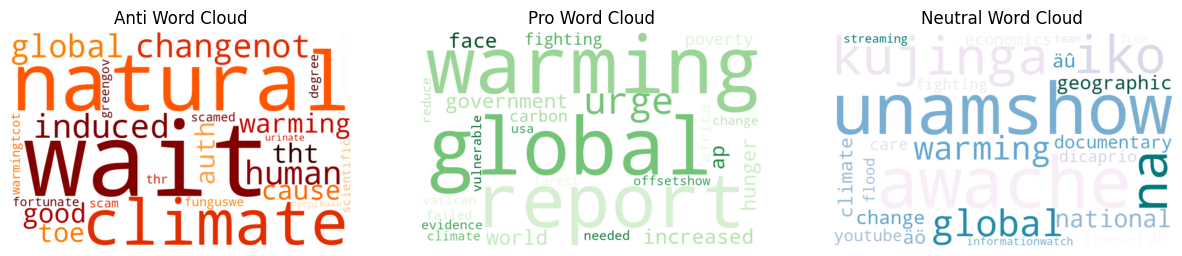

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Anti Word Cloud
axes[0].imshow(anti_wc, interpolation='bilinear')
axes[0].set_title('Anti Word Cloud')
axes[0].axis('off')

# Plot Pro Word Cloud
axes[1].imshow(pro_wc, interpolation='bilinear')
axes[1].set_title('Pro Word Cloud')
axes[1].axis('off')

# Plot Neutral Word Cloud
axes[2].imshow(neutral_wc, interpolation='bilinear')
axes[2].set_title('Neutral Word Cloud')
axes[2].axis('off')

# Show the plot
plt.show()


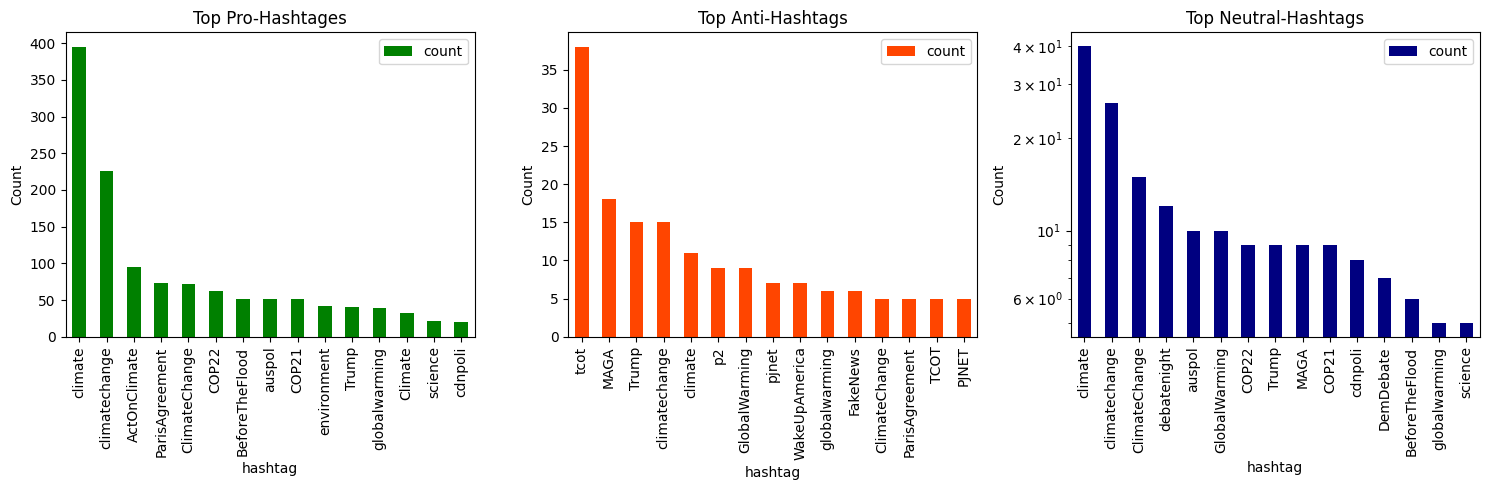

In [17]:
# Hashtag frequency visualisation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.yscale('log')

# Plot top hashtags for each sentiment category
pro_hashtags.set_index('hashtag').plot(kind='bar', ax=axes[0], color='green', title='Top Pro-Hashtages')
axes[0].set_ylabel('Count')

anti_hashtags.set_index('hashtag').plot(kind='bar', ax=axes[1], color='orangered', title='Top Anti-Hashtags')
axes[1].set_ylabel('Count')

neutral_hashtags.set_index('hashtag').plot(kind='bar', ax=axes[2], color='navy', title='Top Neutral-Hashtags')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



Sentiment Analysis: Naive Bayes and Linear SVC

In [18]:
# Separate dataset into feature and target variables
x = df['lemma']
y = df['label']

# Dividing data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=42)

# Vectorize text to numbers
vec = CountVectorizer(stop_words='english')
x_train = vec.fit_transform(x_train).toarray()
x_test = vec.transform(x_test).toarray()


In [19]:
# Naive Bayes Approach
nb = MultinomialNB()
nb.fit(x_train, y_train)
nb.score(x_test, y_test)

nb_pred = nb.predict(x_test)
accuracy = accuracy_score(y_test, nb_pred)
f1 = f1_score(y_test, nb_pred, average="weighted")
print(classification_report(y_test, nb_pred))


Accuracy: 0.7003529034327879
F1 Score: 0.6371875170340068
              precision    recall  f1-score   support

        -1.0       0.82      0.18      0.29       747
         0.0       0.63      0.21      0.32      1443
         1.0       0.70      0.97      0.82      4044

    accuracy                           0.70      6234
   macro avg       0.72      0.45      0.47      6234
weighted avg       0.70      0.70      0.64      6234



In [1]:
# Predict sentiment for test_df using Naive Bayes
test_df['nb_sentiment'] = nb.predict(test_df['tweet'])

NameError: name 'nb' is not defined

In [8]:
!git add /content/myfiles/MyDrive/Colab_Notebooks/climate_change_stance_analysis.ipynb

From https://git.cs.bham.ac.uk/projects-2023-24/rxs008
 * branch            main       -> FETCH_HEAD
Already up to date.
